In [1]:
import matplotlib
import matplotlib.pyplot as plt


In [2]:
import networkx as nx
import community
import pandas as pd

import numpy as np
import json


In [3]:
import collections

In [4]:
from networkx.algorithms.community import greedy_modularity_communities


In [5]:
from importlib.machinery import SourceFileLoader

tools = SourceFileLoader("tools", "../tools.py").load_module()

from tools import write_to_file, test_kruskal


In [6]:
%matplotlib inline

import matplotlib.patches as mpatches
import matplotlib.lines as lines

font = {'size'   : 10,
        'weight': 'bold'}
matplotlib.rc('font', **font)

In [7]:
df = pd.read_csv("../data/prisoners_dilemma_articles_meta_data_clean.csv")


In [8]:
periods = np.sort(df["date"].unique())
periods = periods[~np.isnan(periods)]
periods = periods[1:]

 Collaborativeness 
---------------------------

In [9]:
graph = nx.read_gml("../data/networks/pd_new_graph.gml")

Illustrating co-authors network
------------------------

**Use Gephi**

Network Metrics
-----------------------

In [10]:
number_edges = nx.number_of_edges(graph)
number_nodes = nx.number_of_nodes(graph)


In [11]:
for filename, metric in zip(["pd_edges.txt", "pd_unique_authors.txt"],
                            [number_edges, number_nodes]
):
    write_to_file(filename=filename, metric=metric)


In [12]:
def fix_names_for_table(name):
    name = name.title()
    return name



Collaborative Behaviour
-----------------------------

In [13]:
def collaborative_metrics_of_graph(graph):
    """
    Returns the following metrics:
    - number of nodes
    - number of edges
    - number of isolated authors
    - percentage of isolated authors
    - number of connected components
    - size of the largest connected component
    - average degree
    - clustering coefficients
    - modularity
    """
    num_nodes = nx.number_of_nodes(graph)
    num_edges = nx.number_of_edges(graph)
    isolated_nodes = len(list(nx.isolates(graph)))
    percentage_isolated_nodes = np.round(isolated_nodes / num_nodes, 3) * 100
    number_connected_components = nx.number_connected_components(graph)
    size_of_largest_cc = len(max(nx.connected_components(graph), key=len))

    degree_distribution = sorted([d for n, d in graph.degree()], reverse=True)
    av_degree = np.round(np.mean(degree_distribution), 3)

    clustering_coeff = round(nx.average_clustering(graph), 3)

    try:
        number_of_communities = len(list(greedy_modularity_communities(graph)))
    except ZeroDivisionError:
        number_of_communities = "-"

    communities = community.best_partition(graph)
    try:
        modularity = community.modularity(partition=communities, graph=graph)
    except ValueError:
        modularity = "-"

    metrics = {
        "# Nodes": num_nodes,
        "# Edges": num_edges,
        "# Isolated nodes": isolated_nodes,
        "% Isolated nodes": round(percentage_isolated_nodes, 3),
        "# Connected components": number_connected_components,
        "Size of largest component": size_of_largest_cc,
        "Av. degree": av_degree,
        "Clustering coeff": clustering_coeff,
        "# Communities": number_of_communities,
        "Modularity": modularity,
    }

    return metrics, degree_distribution


**Network Metrics**

In [178]:
metrics = collaborative_metrics_of_graph(graph)[0]


In [179]:
metrics


{'# Nodes': 4011,
 '# Edges': 7642,
 '# Isolated nodes': 128,
 '% Isolated nodes': 3.2,
 '# Connected components': 947,
 'Size of largest component': 796,
 'Av. degree': 3.811,
 'Clustering coeff': 0.701,
 '# Communities': 967,
 'Modularity': 0.9654119207610471}

In [16]:
degree_dstrs = collaborative_metrics_of_graph(graph)[1]

In [17]:
for key in metrics:
    filename = key.replace(" ", "_").replace("#", "num").replace("%", "perce") + ".txt"
    write_to_file(filename, metrics[key])


**Analysing clusters**

In [18]:
center_cluster = max(nx.connected_component_subgraphs(graph), key=len)


In [19]:
center_cluster_metrics = collaborative_metrics_of_graph(center_cluster)[0]


In [20]:
center_cluster_degrees = collaborative_metrics_of_graph(center_cluster)[1]



**Tables**

In [175]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]


In [176]:
metrics_table = pd.DataFrame.from_dict([metrics, center_cluster_metrics])
metrics_table.index = [r"$G$", r"$\bar{G}$"]

In [177]:
metrics_table = metrics_table[columns_order]

KeyError: "None of [Index(['# Nodes', '# Edges', '# Isolated nodes', '% Isolated nodes',\n       '# Connected components', 'Size of largest component', 'Av. degree',\n       '# Communities', 'Modularity', 'Clustering coeff'],\n      dtype='object')] are in the [columns]"

In [24]:
write_to_file(metric=metrics_table.to_latex(), filename="network_comparison.tex")


**Degree Distribution**

In [25]:
max(degree_dstrs)


59

In [26]:
colors = [None, "darkgreen"]
labels = [r'$G$', r'$\bar{G}$']

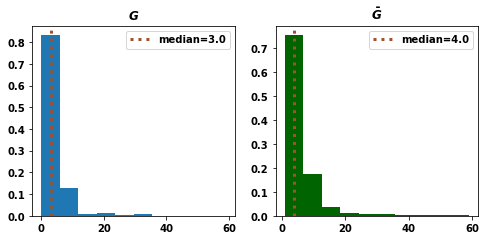

In [27]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))

for i, measure in enumerate([degree_dstrs, center_cluster_degrees]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="sienna",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")
    axes[i].set_title(labels[i])

    axes[i].legend();

plt.savefig("../../assets/images/networks_ditributions.pdf")


In [28]:
temp = pd.DataFrame(degree_dstrs)
temp.describe()

,0
count,4011.000000
mean,3.810521
std,4.415118
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,59.000000


Cumulative Graphs
---------

In [29]:
linestyle = [":o", "-.", "--"]


In [30]:
import glob


In [85]:
years = sorted(df.date.unique())

In [86]:
cumulative_graphs = []
for year in years[:-1]:
    cumulative_graphs.append(nx.read_gml(f"../data/networks/yearly/G_pd_{int(year)}.gml"))


In [87]:
len(cumulative_graphs)

57

In [88]:
cumulative_clusters = [max(nx.connected_component_subgraphs(G), key=len) for G in cumulative_graphs[6:]]


In [89]:
len(cumulative_graphs), len(cumulative_clusters)


(57, 51)

In [90]:
cumulative_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_graphs[6:]
]


In [94]:
cumulative_cluster_metrics = [collaborative_metrics_of_graph(G)[0] for G in cumulative_clusters]


In [95]:
len(cumulative_cluster_metrics)

51

**Tables**

In [38]:
# with open("../../assets/periods_dictionary.json") as json_file:
#     periods_dictionary = json.load(json_file)

In [39]:
cumulative_table = pd.DataFrame.from_dict(cumulative_metrics).round(3)
cumulative_table = cumulative_table[columns_order]


In [40]:
cumulative_table.head(15)


,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
0,6,3,0,0.0,3,2,1.000,3,0.667,0.000
1,8,4,0,0.0,4,2,1.000,4,0.750,0.000
2,19,15,0,0.0,8,5,1.579,8,0.684,0.228
3,20,17,0,0.0,8,6,1.700,8,0.630,0.250
4,22,18,0,0.0,9,6,1.636,9,0.667,0.227
5,33,28,0,0.0,13,6,1.697,13,0.827,0.424
6,39,34,0,0.0,15,6,1.744,15,0.867,0.513
7,42,35,1,2.4,17,6,1.667,17,0.873,0.476
8,42,35,1,2.4,17,6,1.667,17,0.873,0.476
9,42,35,1,2.4,17,6,1.667,17,0.873,0.476


In [41]:
cumulative_table.describe()

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,# Communities,Modularity,Clustering coeff
count,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000,51.000000
mean,616.352941,949.588235,28.960784,5.468627,181.529412,82.921569,1.973294,183.352941,0.911647,0.452000
std,1038.107525,1893.650519,37.154252,3.989661,260.653897,188.097086,0.706136,264.912501,0.088736,0.144216
min,6.000000,3.000000,0.000000,0.000000,3.000000,2.000000,1.000000,3.000000,0.630000,0.000000
25%,47.000000,40.000000,1.000000,2.400000,18.000000,6.000000,1.603000,18.000000,0.884000,0.398500
50%,106.000000,81.000000,12.000000,4.400000,47.000000,6.000000,1.693000,47.000000,0.947000,0.454000
75%,586.000000,539.500000,42.000000,8.450000,230.000000,20.500000,1.862000,230.000000,0.969500,0.505000
max,4011.000000,7642.000000,128.000000,12.900000,947.000000,796.000000,3.811000,967.000000,0.987000,0.701000


In [42]:
write_to_file(
    metric=cumulative_table.to_latex(), filename="cumulative_graphs_table.tex"
)


In [96]:
clusters_cum_table = pd.DataFrame.from_dict(cumulative_cluster_metrics).round(3)
clusters_cum_table = clusters_cum_table[columns_order]


In [97]:
write_to_file(
    metric=clusters_cum_table.to_latex(), filename="cumulative_clusters_table.tex"
)


**Centralities**

In [102]:
betweeness = sorted(nx.betweenness_centrality(graph).items(), key=lambda x: x[1], reverse=True)
closeness = sorted(nx.closeness_centrality(graph).items(), key=lambda x: x[1], reverse=True)

In [103]:
betweeness_cluster = sorted(nx.betweenness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)
closeness_cluster = sorted(nx.closeness_centrality(center_cluster).items(), key=lambda x: x[1], reverse=True)

In [110]:
labels = ['Betweenness', 'Closeness']

In [111]:
tables = []
for i, measure in enumerate([betweeness, closeness, betweeness_cluster, closeness_cluster]):
    table = pd.DataFrame(measure[:10], columns=["Name", labels[int(i % 2)]])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table)     


In [112]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="centralities_pd_graph.tex"
)

**Distributions**

In [106]:
distributions_betweeness = [point[1] for point in betweeness]
distributions_closeness = [point[1] for point in closeness]

In [107]:
distributions_betweeness_cluster = [point[1] for point in betweeness_cluster]
distributions_closeness_cluster = [point[1] for point in closeness_cluster]

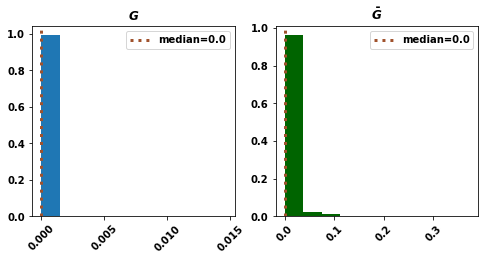

In [108]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))
labels = [r'$G$', r'$\bar{G}$']


for i, measure in enumerate([distributions_betweeness, distributions_betweeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="sienna",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={median}")

    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)
    
    axes[i].set_title(labels[i])

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_betweeness_centralities.pdf", bbox_inches='tight')

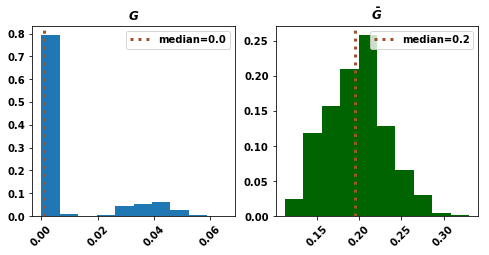

In [109]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 3.5))

for i, measure in enumerate([distributions_closeness,
                                  distributions_closeness_cluster]):
    
    weights = np.ones_like(measure) / float(len(measure))

    axes[i].hist(measure, weights=weights, color=colors[i])
    median = np.median(measure)
    axes[i].axvline(median,
                    color="sienna",
                    linestyle=":",
                    linewidth=3,
                    label=f"median={round(median, 2)}")
    axes[i].set_title(labels[i])
    
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

    axes[i].legend();
    
fig.savefig("../../assets/images/pd_closeness_centralities.pdf", bbox_inches='tight')

Topics
=====

In [53]:
data_with_topics = pd.read_csv('../data/prisoners_dilemma_meta_data_with_topics.csv')

In [54]:
names = df['author']

In [55]:
names = [tools.normalise_name(name) for name in names]

In [113]:
data_with_topics['author_standarized'] = names

In [114]:
counts = data_with_topics[['author_standarized',
                           'Dominant_Topic']].drop_duplicates().groupby('author_standarized').count()

In [121]:
len(counts[counts.values == 1])

2246

In [123]:
len(counts[counts.values > 1])

1975

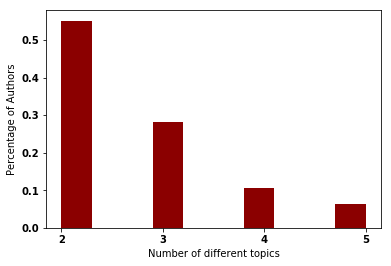

In [58]:
fig, ax = plt.subplots()

measure = counts[counts['Dominant_Topic'] > 1].values

weights = np.ones_like(measure) / float(len(measure))

ax.hist(measure, weights=weights, color='darkred')
ax.set_xticks([2, 3, 4, 5]);

ax.set_xlabel('Number of different topics');
ax.set_ylabel('Percentage of Authors');

plt.savefig("../../assets/images/percentage_of_authors_different_topic.pdf", bbox_inches="tight")

In [59]:
total = len(counts[counts['Dominant_Topic'] == 2].values)

In [60]:
replace = {'0.0': 'A',
           '1.0': 'B',
           '2.0': 'C',
           '3.0': 'D',
           '4.0': 'E',
          }

In [133]:
labels = ['A', 'B', 'C', 'D', 'E']

In [136]:
from_ = []
to_ = []
values = []
for number in range(2, 6):
    total = len(counts[counts['Dominant_Topic'] == number].values)
    topics = []
    for name in counts[counts['Dominant_Topic'] == number].index:
        groups = data_with_topics[data_with_topics['author_standarized'] == name]['Dominant_Topic'].unique()
        topics.append(groups)
    topics = [tuple(topic) for topic in topics]
    counter = collections.Counter(tuple(sorted(tup)) for tup in topics)

    for key in counter.keys():
        from_.append(str([labels[int(i)] for i in key]))
        
        values.append(round(counter[key] / total, 2))

In [137]:
write_to_file(metric=pd.DataFrame({'From': from_,
              'Probabilities': values}).replace(replace).to_latex(), filename="topic_probabilities.tex")
              

In [162]:
authors_that_write_in_many_topics = counts[counts['Dominant_Topic'] > 1].index

In [169]:
for i in range(2, 5):
    isolated = list(nx.isolates(graphs[i]))
    print(sum([author in authors_that_write_in_many_topics for author in isolated]) / len(isolated))

0.926829268292683
0.8823529411764706
0.7966101694915254


In [174]:
[graphs[3].edges(author) for author in authors_that_write_in_many_topics]

[EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([('A. Cardillo', 'J. Gomez-Gardenes'), ('A. Cardillo', 'A. Sanchez'), ('A. Cardillo', 'D. Vilone')]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([('A. Elgazzar', 'E. Ahmed'), ('A. Elgazzar', 'A. Hegazi')]),
 EdgeDataView([]),
 EdgeDataView([('A. Hegazi', 'E. Ahmed'), ('A. Hegazi', 'A. Elgazzar')]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([('Adam Kun', 'Ulf Dieckmann')]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([('Adauto Souza', 'Luciano Miranda'), ('Adauto Souza', 'Fernando Ferreira'), ('Adauto Souza', 'Paulo Campos')]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDataView([]),
 EdgeDat

In [164]:
isolated

['Wilfried Engelmann',
 'C. Sheng',
 'John Carroll',
 'Lothar Philipps',
 'Ishtiyaque Haji',
 'Elliott Sober',
 'Mark Walker',
 'Kevin Gibson',
 'Jose Bermudez',
 'John Tilley',
 'Mark Lichbach',
 'Mark White',
 'Miriam Bentwich',
 'Pilwon Kim',
 'J.C. Oh',
 'Koichi Moriyama',
 "Salvatore Sarcia'",
 'Mubarak Al-Mutairi',
 'Jingyu Pan',
 'John Paravantis',
 'Michael Swearingen',
 'Shen Tao',
 'H. Brock',
 'G. Rabow',
 'J.R. Clymer',
 'P. Grim',
 'Kave Salamatian',
 'Mu Weizhe',
 'Baoying Wang',
 'Steven Silverman',
 'Xiaohong Guan',
 'Mohammed Baidas',
 'Nadiya Kostyuk',
 'Thomas Tarler',
 'Yaming Yu',
 'A. Klimenko',
 'Steven Bleiler',
 'H. Zeh',
 'Jules Hedges',
 'Enrique Guerra-Pujol',
 'Umberto Grandi',
 'Jordi Vallverdu',
 'Caslav Brukner',
 'Jeffrey Tyler',
 'Hiroyasu Inoue',
 'Renato Santos',
 'Gabriel Frahm',
 'Wei Zhang',
 'Bob Coecke',
 'Haoyang Wu',
 'Yaguang Yang',
 'Akos Dobay',
 'Pawel Sobkowicz',
 'Esteban Hidalgo',
 'Vikram Dhillon',
 'Andrew Critch',
 'Tong Wang',
 'Bei

**Graphs**

In [147]:
graphs = []
number_of_topics = 5
for number in range(number_of_topics):
    graphs.append(nx.read_gml(f'../data/networks/topic_{int(number)}_pd_.gml'))

In [65]:
number_edges = [nx.number_of_edges(G) for G in graphs]
number_nodes = [nx.number_of_nodes(G) for G in graphs]

In [66]:
metrics = [collaborative_metrics_of_graph(G)[0] for G in graphs]

In [67]:
degree_dstrs = [collaborative_metrics_of_graph(G)[1] for G in graphs]

In [68]:
columns_order = [
    "# Nodes",
    "# Edges",
    "# Isolated nodes",
    "% Isolated nodes",
    "# Connected components",
    "Size of largest component",
    "Av. degree",
    "# Communities",
    "Modularity",
    "Clustering coeff",
]

In [69]:
topics = ["Topic A", "Topic B", "Topic C", "Topic D", "Topic E"]

In [70]:
metrics_table = pd.DataFrame.from_dict(metrics).round(3)
metrics_table.index = topics

In [71]:
metrics_table

,# Nodes,# Edges,# Isolated nodes,% Isolated nodes,# Connected components,Size of largest component,Av. degree,Clustering coeff,# Communities,Modularity
Topic A,1124,2137,15,1.3,264,56,3.802,0.759,265,0.983
Topic B,695,1382,13,1.9,157,80,3.977,0.773,158,0.950
Topic C,900,1141,41,4.6,281,29,2.536,0.636,281,0.981
Topic D,880,1509,17,1.9,174,312,3.430,0.701,183,0.918
Topic E,1045,1964,59,5.6,354,31,3.759,0.664,354,0.926


In [72]:
metrics_table = metrics_table[columns_order]

In [73]:
write_to_file(metric=metrics_table.to_latex(), filename="topic_network_comparison.tex")

In [74]:
betweeness = [
    sorted(nx.betweenness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]



In [75]:
closeness = [
    sorted(nx.closeness_centrality(G).items(), key=lambda x: x[1], reverse=True)
    for G in graphs
]


In [76]:
tables = []
for measure in betweeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Betweeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [77]:
pd.concat(tables, axis=1)

,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness,Name,Betweeness
1,David Rand,0.001570,Long Wang,0.006306,Daniel Ashlock,0.000655,Matjaz Perc,0.063534,Zengru Di,0.000096
2,Valerio Capraro,0.001252,Luo-Luo Jiang,0.004566,Matjaz Perc,0.000453,Luo-Luo Jiang,0.036631,Jian Yang,0.000033
3,Angel Sanchez,0.000555,Martin Nowak,0.004203,Karl Tuyls,0.000436,Yamir Moreno,0.031429,Yevgeniy Vorobeychik,0.000026
4,Feng Fu,0.000533,Matjaz Perc,0.003476,Philip Hingston,0.000327,Christoph Hauert,0.027449,Otavio Teixeira,0.000022
5,Martin Nowak,0.000484,Attila Szolnoki,0.002707,Eun-Youn Kim,0.000286,Long Wang,0.024083,Roberto Oliveira,0.000022
6,Nicholas Christakis,0.000350,Christian Hilbe,0.002362,Wendy Ashlock,0.000260,Zhen Wang,0.023949,M. Nowak,0.000020
7,Pablo Branas-Garza,0.000340,Yamir Moreno,0.002362,Attila Szolnoki,0.000225,Han-Xin Yang,0.022656,M. Harper,0.000011
8,Toshio Yamagishi,0.000305,Xiaojie Chen,0.002170,Seung Baek,0.000216,Martin Nowak,0.019746,Xiao Han,0.000011
9,James Fowler,0.000300,Arne Traulsen,0.001950,Martin Nowak,0.000211,Angel Sanchez,0.016911,Zhesi Shen,0.000011
10,Long Wang,0.000248,Zhen Wang,0.001821,Thore Graepel,0.000193,Zhihai Rong,0.015619,Wen-Xu Wang,0.000011


In [78]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="betweeness_topics_graphs.tex"
)

In [79]:
tables = []
for measure in closeness:
    table = pd.DataFrame(measure[:10], columns=["Name", "Closeness"])
    table.Name = [fix_names_for_table(name) for name in table.Name]
    table.index += 1
    tables.append(table) 

In [80]:
write_to_file(
    metric=pd.concat(tables, axis=1).round(3).to_latex(), filename="closeness_topics_graphs.tex"
)

In [81]:
distributions_betweeness = [[point[1] for point in coeff] for coeff in betweeness]

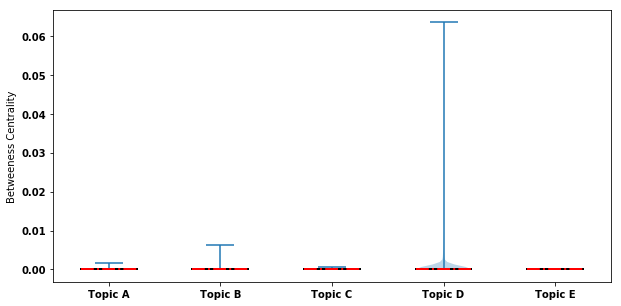

In [82]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.violinplot(distributions_betweeness)
boxes = plt.boxplot(distributions_betweeness, showfliers=False)

for bp in boxes['medians']:
    bp.set_color('red')
    bp.set_linewidth(2)
    bp.set_linestyle('-.')
for bp in boxes['caps']:
    bp.set_color('black')
    bp.set_linewidth(2)
for bp in boxes['whiskers']:
    bp.set_color('black')
    bp.set_linewidth(2)
for bp in boxes['boxes']:
    bp.set_color('black')
    bp.set_linewidth(2)

# axes.set_ylim([0, 0.02]);
axes.set_ylabel('Betweeness Centrality')
axes.set_xticks(range(1, 6))
axes.set_xticklabels(topics);

plt.savefig("../../assets/images/topics_betweeness_distributions.pdf", bbox_inches="tight")

In [83]:
distributions_close = [[point[1] for point in coeff] for coeff in closeness]


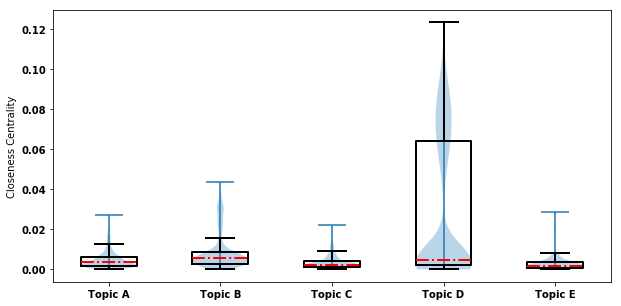

In [84]:
fig, axes = plt.subplots(figsize=(10, 5))
plt.violinplot(distributions_close)
boxes = plt.boxplot(distributions_close, showfliers=False)

for bp in boxes['medians']:
    bp.set_color('red')
    bp.set_linewidth(2)
    bp.set_linestyle('-.')
for bp in boxes['caps']:
    bp.set_color('black')
    bp.set_linewidth(2)
for bp in boxes['whiskers']:
    bp.set_color('black')
    bp.set_linewidth(2)
for bp in boxes['boxes']:
    bp.set_color('black')
    bp.set_linewidth(2)

# axes.set_ylim([0, 0.01]);
axes.set_ylabel('Closeness Centrality')
axes.set_xticks(range(1, 6))
axes.set_xticklabels(topics);

plt.savefig("../../assets/images/topics_closeness_distributions.pdf", bbox_inches="tight")